In [ ]:
!pip install -q pydicom tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Where your original LIDC patient folders are
SRC_ROOT = "/content/drive/MyDrive/Lung cancer Dataset/First 100 patients"

# Where we will store CT-only data
DST_ROOT = "/content/drive/MyDrive/CT_scan_images"

os.makedirs(DST_ROOT, exist_ok=True)


In [ ]:
import pydicom

def is_ct_series(folder_path):
    """
    Returns True if this folder contains CT DICOM images
    """
    for f in os.listdir(folder_path):
        if f.lower().endswith(".dcm"):
            try:
                ds = pydicom.dcmread(
                    os.path.join(folder_path, f),
                    stop_before_pixels=True
                )
                return ds.Modality == "CT"
            except:
                return False
    return False


In [ ]:
def find_ct_series_for_patient(patient_path):
    """
    Walks through a patient directory and finds CT series folders
    """
    ct_series_folders = []

    for root, dirs, files in os.walk(patient_path):
        dcm_files = [f for f in files if f.lower().endswith(".dcm")]
        if not dcm_files:
            continue

        if is_ct_series(root):
            ct_series_folders.append(root)

    return ct_series_folders


In [ ]:
import shutil
from tqdm import tqdm

patient_folders = sorted([
    d for d in os.listdir(SRC_ROOT)
    if d.startswith("LIDC-IDRI-")
])

print("Total patients found:", len(patient_folders))


Total patients found: 100


In [ ]:
for patient_id in tqdm(patient_folders, desc="Processing patients"):
    patient_src_path = os.path.join(SRC_ROOT, patient_id)
    patient_dst_path = os.path.join(DST_ROOT, patient_id)

    os.makedirs(patient_dst_path, exist_ok=True)

    ct_series = find_ct_series_for_patient(patient_src_path)

    if len(ct_series) == 0:
        print(f"⚠️ No CT found for {patient_id}")
        continue

    for idx, series_path in enumerate(ct_series, start=1):
        series_dst = os.path.join(patient_dst_path, f"series_{idx}")
        os.makedirs(series_dst, exist_ok=True)

        for f in os.listdir(series_path):
            if f.lower().endswith(".dcm"):
                src_file = os.path.join(series_path, f)
                dst_file = os.path.join(series_dst, f)
                shutil.copy2(src_file, dst_file)


Processing patients: 100%|██████████| 100/100 [57:09<00:00, 34.29s/it]


In [ ]:
!pip install -q pydicom numpy tqdm matplotlib


In [ ]:
import os

SRC_ROOT = "/content/drive/MyDrive/CT_scan_images"
DST_ROOT = "/content/drive/MyDrive/CT_HU_Windowed"

os.makedirs(DST_ROOT, exist_ok=True)


In [ ]:
import pydicom
import numpy as np

def dicom_to_hu(ds):
    image = ds.pixel_array.astype(np.int16)

    slope = float(ds.RescaleSlope) if "RescaleSlope" in ds else 1.0
    intercept = float(ds.RescaleIntercept) if "RescaleIntercept" in ds else 0.0

    hu = image * slope + intercept
    return hu


In [ ]:
def lung_window(hu, center=-600, width=1500):
    min_hu = center - width // 2
    max_hu = center + width // 2
    hu = np.clip(hu, min_hu, max_hu)
    return hu


In [ ]:
from tqdm import tqdm

def process_patient(patient_id):
    patient_src = os.path.join(SRC_ROOT, patient_id)
    patient_dst = os.path.join(DST_ROOT, patient_id)
    os.makedirs(patient_dst, exist_ok=True)

    for series_name in os.listdir(patient_src):
        series_src = os.path.join(patient_src, series_name)
        series_dst = os.path.join(patient_dst, series_name)
        os.makedirs(series_dst, exist_ok=True)

        dcm_files = sorted([
            f for f in os.listdir(series_src)
            if f.lower().endswith(".dcm")
        ])

        for idx, dcm_file in enumerate(dcm_files):
            dcm_path = os.path.join(series_src, dcm_file)
            ds = pydicom.dcmread(dcm_path)

            hu = dicom_to_hu(ds)
            hu = lung_window(hu)

            out_path = os.path.join(series_dst, f"slice_{idx:03d}.npy")
            np.save(out_path, hu)


In [ ]:
process_patient("LIDC-IDRI-0001")


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

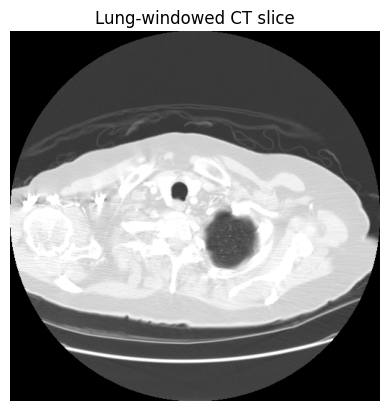

In [ ]:
import matplotlib.pyplot as plt

sample_slice = np.load(
    "/content/drive/MyDrive/CT_HU_Windowed/LIDC-IDRI-0001/series_1/slice_010.npy"
)

plt.imshow(sample_slice, cmap="gray")
plt.title("Lung-windowed CT slice")
plt.axis("off")


In [ ]:
from tqdm import tqdm

patients = sorted(os.listdir(SRC_ROOT))

for pid in tqdm(patients):
    patient_dst = os.path.join(DST_ROOT, pid)

    # Skip if already processed
    if os.path.exists(patient_dst) and len(os.listdir(patient_dst)) > 0:
        print(f"Skipping {pid} (already processed)")
        continue

    process_patient(pid)


  0%|          | 0/100 [00:00<?, ?it/s]

Skipping LIDC-IDRI-0001 (already processed)


100%|██████████| 100/100 [2:00:31<00:00, 72.32s/it] 


In [ ]:
import os

print(len(os.listdir(DST_ROOT)))
print(os.listdir(DST_ROOT)[:5])


100
['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003', 'LIDC-IDRI-0004', 'LIDC-IDRI-0005']


In [ ]:
import os

ROOT = "/content/drive/MyDrive/CT_HU_Windowed"


In [ ]:
patients_with_no_slices = []

for patient_id in sorted(os.listdir(ROOT)):
    patient_path = os.path.join(ROOT, patient_id)

    if not os.path.isdir(patient_path):
        continue

    series_folders = [
        d for d in os.listdir(patient_path)
        if os.path.isdir(os.path.join(patient_path, d))
    ]

    total_slices = 0

    for series in series_folders:
        series_path = os.path.join(patient_path, series)
        slices = [f for f in os.listdir(series_path) if f.endswith(".npy")]
        total_slices += len(slices)

    if total_slices == 0:
        patients_with_no_slices.append(patient_id)

print("Patients with NO slices:", patients_with_no_slices)
print("Count:", len(patients_with_no_slices))


Patients with NO slices: []
Count: 0


In [ ]:
for patient_id in sorted(os.listdir(ROOT)):
    patient_path = os.path.join(ROOT, patient_id)

    if not os.path.isdir(patient_path):
        continue

    total_slices = 0
    series_info = {}

    for series in os.listdir(patient_path):
        series_path = os.path.join(patient_path, series)
        if not os.path.isdir(series_path):
            continue

        slices = [f for f in os.listdir(series_path) if f.endswith(".npy")]
        series_info[series] = len(slices)
        total_slices += len(slices)

    print(f"{patient_id}: total slices = {total_slices}, per series = {series_info}")


LIDC-IDRI-0001: total slices = 133, per series = {'series_1': 133}
LIDC-IDRI-0002: total slices = 261, per series = {'series_1': 261}
LIDC-IDRI-0003: total slices = 140, per series = {'series_1': 140}
LIDC-IDRI-0004: total slices = 241, per series = {'series_1': 241}
LIDC-IDRI-0005: total slices = 133, per series = {'series_1': 133}
LIDC-IDRI-0006: total slices = 133, per series = {'series_1': 133}
LIDC-IDRI-0007: total slices = 145, per series = {'series_1': 145}
LIDC-IDRI-0008: total slices = 133, per series = {'series_1': 133}
LIDC-IDRI-0009: total slices = 256, per series = {'series_1': 256}
LIDC-IDRI-0010: total slices = 277, per series = {'series_1': 277}
LIDC-IDRI-0011: total slices = 128, per series = {'series_1': 128}
LIDC-IDRI-0012: total slices = 128, per series = {'series_1': 128}
LIDC-IDRI-0013: total slices = 125, per series = {'series_1': 125}
LIDC-IDRI-0014: total slices = 114, per series = {'series_1': 114}
LIDC-IDRI-0015: total slices = 209, per series = {'series_1': 